# Laboratório 6
Material desenvolvido por Henrique Margotte e Aurora Pozo para a disciplina de Aprendizado de Máquina, para o curso de Informática Biomédica da UFPR, semestre 2025/2. Códigos baseados em exemplos da biblioteca scikit-learn e nos notebooks Python do livro "Inteligência Artificial: Uma Abordagem de Aprendizado de Máquina", 2ª edição.

# Exemplo 1: AutoEncoders
No laboratório de hoje, veremos uma técnica diferente de Aprendizado de Máquina, os AutoCodificadores, ou AutoEncoders (AE). Os AEs são considerados como um método de aprendizado auto-supervisionado (ou _self supervised learning_), em que o próprio modelo define as "classes", para funcionar de modo semelhante ao aprendizado supervisionado. O AE funciona de modo que a entrada e saída esperada do modelo são iguais, ou seja, o modelo vai apenas aprender como copiar a entrada para a saída! Dessa forma, não precisamos rotular os dados, mas temos o objetivo de cada entrada bem definido! Os Grandes Modelos de Linguagem (LLMs) também se encaixam nesse método de aprendizado, sendo treinados com as palavras anteriores tentando prever a próxima palavra dentro de um mesmo texto.

Mas... isso não seria apenas copiar a entrada para a saída? Só fazendo os neurônios replicarem a entrada sem a alterarem? Sim, _seria_. A diferença é que os AEs possuem uma estrutura própria, dividida em duas partes:
- Codificador (*Encoder*): Conjunto de camadas que recebe os dados de entrada e processá-os, os "codificando" para um vetor de tamanho menor do que a entrada, chamado de Vetor Latente (*Feature Vector*), que é gerado como saída do Codificador.
- Decodificador (*Decoder*): Conjunto de camadas que recebe o Vetor Latente como entrada e o transforma na saída esperada.

## Exemplo 1.1: AutoEncoders com scikit-learn
Vamos ver um exemplo da aplicação de um AE no scikit-learn. Podemos fazer isso utilizando um `MLPRegressor`, definindo o tamanho das camadas no formado codificador-decodificador. O modelo de regressão é mais apropriado pois queremos minimizar o erro, ou diferença, entre a entrada e a saída.

Como exemplo, utilizremos imagens de gatos e cachorros da base de dados `CIFAR-10`, integrada ao Keras.

In [6]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Load dataset ---
# 'as_supervised=True' returns (image, label)
dataset, info = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

# --- Split and take a small subset for demonstration ---
train_ds = dataset['train']

# Shuffle and take only 1000 samples to keep it light
train_ds = train_ds.shuffle(1000, seed=42).take(1000)

# Resize and normalize
def preprocess(image, label):
    image = tf.image.resize(image, (64, 64))   # Resize to smaller images
    image = tf.cast(image, tf.float32) / 255.0 # Normalize to [0,1]
    return image, label

train_ds = train_ds.map(preprocess).batch(32).prefetch(1)

/home/margotte/Aprendizado-de-Maquina-2025-2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]2025-10-09 18:50:54.153887: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
                                            

Dataset cats_vs_dogs downloaded and prepared to /home/margotte/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


2025-10-09 18:51:51.669882: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-10-09 18:51:51.843711: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


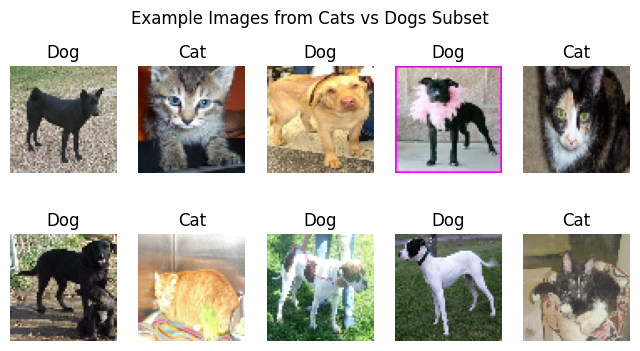

In [7]:
plt.figure(figsize=(8, 4))
for images, labels in train_ds.take(1):
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title("Cat" if labels[i].numpy() == 0 else "Dog")
        plt.axis('off')
plt.suptitle("Example Images from Cats vs Dogs Subset")
plt.show()
